# Numerical Solvers

Brain modeling toolkit provided in BrainPy is focused on **differential equations**. How to solve differential equations is the essence of the neurodynamics simulation. The exact algebraic solutions are only available for low-order differential equations. For the coupled high-dimensional non-linear brain dynamical systems, we need to resort to using numerical methods for solving such differential equations. 

In this section, I will illustrate how to define ordinary differential quations (ODEs), stochastic differential equations (SDEs), and how to define the numerical integration methods for them in BrainPy.

In [1]:
import brainpy as bp

bp.__version__

'1.1.0rc1'

## ODEs

### How to define ODE functions?

BrainPy provides a convenient and intuitive way to define ODE systems. For the ODE

$$
{dx \over dt} = f_1(x, t, y, p_1)\\
{dy \over dt} = f_2(y, t, x, p_2)
$$

we can define this system as a Python function: 

In [2]:
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

where `t` denotes the current time, `p1` and `p2` which after the `t` are represented as parameters needed in this system, and `x` and `y` passed before `t` denotes the dynamical variables. In the function body, the derivative for each variable can be customized by the user need `f1` and `f2`. Finally, we return the corresponding derivatives `dx` and `dy` with the order the same as the variables in the function arguments.

For each variable `x` or `y`, it can be a scalar (`var_type = bp.integrators.SCALAR_VAR`), a vector/matrix (`var_type = bp.integrators.POP_VAR`), or a system (`var_type = bp.integrators.SYSTEM_VAR`). Here, the "system" means that the argument `x` denotes an array of variables. Take the above example as the demonstration again, we can redefine it as:

In [3]:
def diff(xy, t, p1, p2):
    x, y = xy
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return bp.math.array([dx, dy])

### How to define the numerical integration for ODEs?

After the definition of ODE functions, the numerical integration of these functions are very easy in BrainPy. We just need put a decorator (`bp.odeint`). 

In [4]:
@bp.odeint
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

`bp.odeint` receives "method", "dt" etc. specification. By providing "method", user can specify the numerical methods to integrate the ODE functions. The supported ODE method can be found by

In [5]:
bp.integrators.SUPPORTED_ODE_METHODS

['bs',
 'ck',
 'euler',
 'exponential_euler',
 'exponential_midpoint',
 'heun2',
 'heun3',
 'heun_euler',
 'midpoint',
 'ralston2',
 'ralston3',
 'ralston4',
 'rk2',
 'rk3',
 'rk4',
 'rk4_38rule',
 'rkdp',
 'rkf12',
 'rkf45',
 'ssprk3']

Moreover, "dt" is a float which denotes the numerical integration precision. Here, for the above ODE function, we can define a four-order Runge-Kutta method for it:

In [6]:
@bp.odeint(method='rk4', dt=0.01)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

### Example 1: FitzHugh–Nagumo model

Now, let's take the well known [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) as an exmaple to illustrate how to define ODE solvers for brain modeling. The FitzHugh–Nagumo model (FHN) model has two dynamical variables, which are governed by the following equations:

$$
\begin{split}
\tau {\dot  {w}}&=v+a-bw\\
{\dot {v}} &=v-{\frac {v^{3}}{3}}-w+I_{\rm {ext}}
\end{split}
$$

For this FHN model, we can code it in BrainPy like this:

In [7]:
@bp.odeint(dt=0.01)
def integral(V, w, t, Iext, a, b, tau):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

After defining the numerical solver, the solution of the ODE system in the given times can be easily solved. For example, for the given parameters,

In [8]:
a=0.7;   b=0.8;   tau=12.5;   Iext=1.

the solution of the FHN model between 0 and 100 ms can be approximated by 

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

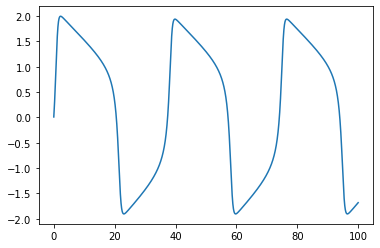

In [10]:
hist_times = bp.math.arange(0, 100, 0.01)
hist_V = []
V, w = 0., 0.
for t in hist_times:
    V, w = integral(V, w, t, Iext, a, b, tau)
    hist_V.append(V)

plt.plot(hist_times, hist_V)

### Example 2: Hodgkin–Huxley model

Another more complex example is the classical [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). In HH model, four dynamical variables (`V, m, n, h`) are used for modeling the initiation and propagration of the action potential. Specificaly, they are governed by the following equations:

$$
\begin{aligned}
C_{m} \frac{d V}{d t} &=-\bar{g}_{\mathrm{K}} n^{4}\left(V-V_{K}\right)- \bar{g}_{\mathrm{Na}} m^{3} h\left(V-V_{N a}\right)-\bar{g}_{l}\left(V-V_{l}\right)+I_{s y n} \\
\frac{d m}{d t} &=\alpha_{m}(V)(1-m)-\beta_{m}(V) m \\
\frac{d h}{d t} &=\alpha_{h}(V)(1-h)-\beta_{h}(V) h \\
\frac{d n}{d t} &=\alpha_{n}(V)(1-n)-\beta_{n}(V) n
\end{aligned}
$$

In BrainPy, such dynamical system can be coded as:

In [11]:
@bp.odeint(method='rk4', dt=0.01)
def integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - bp.math.exp(-(V + 40) / 10))
    beta = 4.0 * bp.math.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bp.math.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bp.math.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bp.math.exp(-(V + 55) / 10))
    beta = 0.125 * bp.math.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

Same as the FHN model, we can also integrate the HH model in the given parameters and time interval:

In [12]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

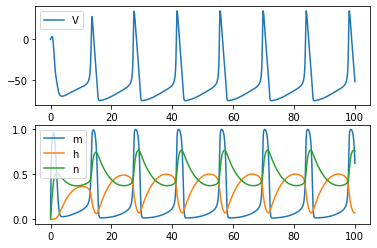

In [13]:
hist_times = bp.math.arange(0, 100, 0.01)
hist_V, hist_m, hist_h, hist_n = [], [], [], []
V, m, h, n = 0., 0., 0., 0.
for t in hist_times:
    V, m, h, n = integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
    hist_V.append(V)
    hist_m.append(m)
    hist_h.append(h)
    hist_n.append(n)

plt.subplot(211)
plt.plot(hist_times, hist_V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(hist_times, hist_m, label='m')
plt.plot(hist_times, hist_h, label='h')
plt.plot(hist_times, hist_n, label='n')
plt.legend()

## SDEs

### How to define SDE functions?

For a one-dimensional stochastic differentiable equation (SDE) with scalar Wiener noise, it is given by

$$
\begin{aligned}
d X_{t}&=f\left(X_{t}, t, p_1\right) d t+g\left(X_{t}, t, p_2\right) d W_{t} \quad (1)
\end{aligned}
$$

where $X_t = X(t)$ is the realization of a stochastic process or random variable, $f(X_t, t)$ is the drift coefficient, $g(X_t, t)$ denotes the diffusion coefficient, the stochastic process $W_t$ is called Wiener process. 

For this SDE system, we can define two Python funtions $f$ and $g$ to represent it.

In [14]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df

Same with the ODE functions, the arguments before $t$ denotes the random variables, while the arguments defined after $t$ represents the parameters.  For the SDE function with scalar noise, the size of the return data $dg$ and $df$ should be the same. For example, $df \in R^d, dg \in R^d$.

However, for a more general SDE system, it usually has multi-dimensional driving Wiener process:

$$
dX_t=f(X_t)dt+\sum_{\alpha=1}^{m}g_{\alpha }(X_t)dW_t ^{\alpha}
$$

For such $m$-dimensional noise system, the coding schema is the same with the scalar ones, but with the difference of that the data size of $dg$ has one more dimension. For example, $df \in R^{d}, dg \in R^{d \times m}$.

### How to define the numerical integration for SDEs?

Brefore the numerical integration of SDE functions, we should distinguish two kinds of SDE integrals. For the integration of system (1), we can get

$$
\begin{aligned}
X_{t}&=X_{t_{0}}+\int_{t_{0}}^{t} f\left(X_{s}, s\right) d s+\int_{t_{0}}^{t} g\left(X_{s}, s\right) d W_{s} \quad (2)
\end{aligned}
$$

In 1940s, the Japanese mathematician K. Ito denoted a type of integral called *Ito stochastic integral*. In 1960s, the Russian physicist R. L. Stratonovich proposed an other kind of stochastic integral called *Stratonovich stochastic integral* and used the symbol "$\circ$" to distinct it from the former Ito integral.

$$
\begin{aligned}
d X_{t} &=f\left(X_{t}, t\right) d t+g\left(X_{t}, t\right) \circ d W_{t} \\
X_{t} &=X_{t_{0}}+\int_{t_{0}}^{t} f\left(X_{s}, s\right) d s+\int_{t_{0}}^{t} g\left(X_{s}, s\right) \circ d W_{s}  \quad (3)
\end{aligned}
$$

The difference of Ito integral (2) and Stratonovich integral (3) lies at the second integral term, which can be written in a general form as

$$
\begin{split}
\int_{t_{0}}^{t} g\left(X_{s}, s\right) d W_{s} &=\lim _{h \rightarrow 0} \sum_{k=0}^{m-1} g\left(X_{\tau_{k}}, \tau_{k}\right)\left(W\left(t_{k+1}\right)-W\left(t_{k}\right)\right) \\
\mathrm{where} \quad & h = t_{k+1} - t_{k} \\
              & \tau_k = (1-\lambda)t_k +\lambda t_{k+1}
\end{split}
$$

- In the stochastic integral of the Ito SDE, $\lambda=0$, thus $\tau_k=t_k$; 

- In the definition of the Stratonovich integral, $\lambda=0.5$, thus $\tau_k=(t_{k+1} + t_{k}) / 2$.

In BrainPy, these two different integrals can be easily implemented. What need the users do is to provide a keyword `sde_type` in decorator `bp.sdeint`. `intg_type` can be "bp.integrators.STRA_SDE" or "bp.integrators.ITO_SDE" (default). Also, the different type of Wiener process can also be easily distinguished by the `wiener_type` keyword. It can be "bp.integrators.SCALAR_WIENER"  (default) or "bp.integrators.VECTOR_WIENER".

Now, let's numerically integrate the SDE (1) by the Ito way with the Milstein method:

In [15]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(d,)

@bp.sdeint(g=g_part, method='milstein')
def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

Or, it can be expressed as:

In [16]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(d,)

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

integral = bp.sdeint(f=f_part, g=g_part, method='milstein')

However, if you try to numerically integrate the SDE with multi-dimensional Wiener process by the Stratonovich ways, you can code it like this:

In [17]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(d, m)

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

integral = bp.sdeint(f=f_part, 
                     g=g_part, 
                     method='milstein', 
                     intg_type=bp.integrators.STRA_SDE, 
                     wiener_type=bp.integrators.SCALAR_WIENER)

### Example 3: Noisy Lorenz system

Here, let's demenstrate how to define a numerical solver for SDEs with the famous [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system): 

$$
\begin{array}{l}
\frac{d x}{dt}&=\sigma(y-x) &+ px*\xi_x \\
\frac{d y}{dt}&=x(\rho-z)-y &+ py*\xi_y\\
\frac{d z}{dt}&=x y-\beta z &+ pz*\xi_z
\end{array}
$$

In [18]:
sigma = 10; beta = 8/3; 
rho = 28;   p = 0.1

def lorenz_g(x, y, z, t):
    return p * x, p * y, p * z

def lorenz_f(x, y, z, t):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

lorenz = bp.sdeint(f=lorenz_f, 
                   g=lorenz_g, 
                   intg_type=bp.integrators.ITO_SDE,
                   wiener_type=bp.integrators.SCALAR_WIENER,
                   dt=0.005)

Text(0.5, 0, 'z')

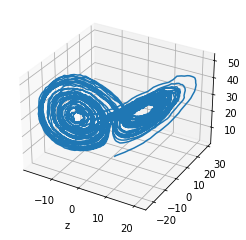

In [19]:
hist_times = bp.math.arange(0, 50, 0.005)
hist_x, hist_y, hist_z = [], [], []
x, y, z = 1., 1., 1.
for t in hist_times:
    x, y, z = lorenz(x, y, z, t)
    hist_x.append(x)
    hist_y.append(y)
    hist_z.append(z)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(hist_x, hist_y, hist_z)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')

---

- Chaoming Wang (adaduo@outlook.com)
- Updated at 2021.05.29

---